In [1]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, lti
import tools

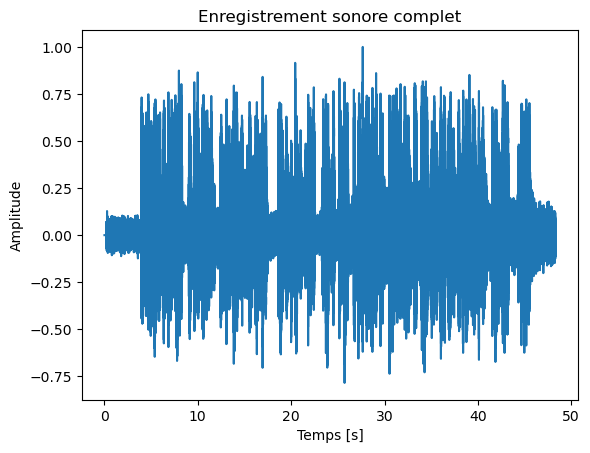

In [2]:
# ===== Chargement du son et normalisation de la valeur des échantillions =====

fs, data = wavfile.read("../wav/vuvuzela.wav")
t = np.arange(len(data))/fs
data_normalized = data/np.max(np.abs(data))

tools.affichage_graph(t, data_normalized, "Temps [s]", "Amplitude", None, None, "Enregistrement sonore complet")

1. Isoler une partie du son ne contenant que des sons de vuvuzela (pas de commentaires
sportifs).

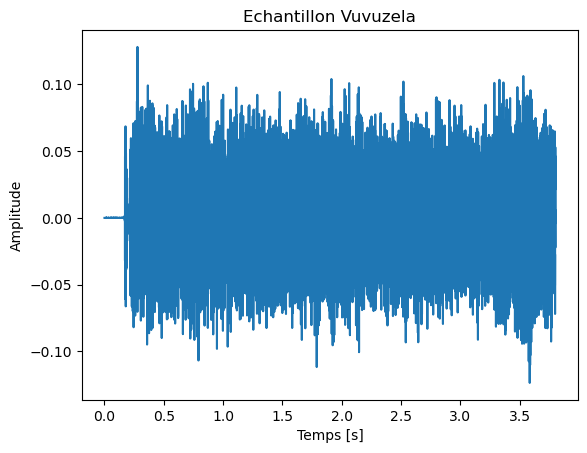

In [3]:
# ===== Isolation du Son de Vuvuzela =====

start_time = 0
end_time = 3.8

start_index = int(start_time * fs)
end_index = int(end_time * fs)

vuvuzela_section = data_normalized[start_index:end_index]

data_vuvuzela_1, t_vuvuzela_1 = tools.isolation_de_son(start_time, end_time, fs, data_normalized)

tools.affichage_graph(t_vuvuzela_1, data_vuvuzela_1, "Temps [s]", "Amplitude", None, None, "Echantillon Vuvuzela")

2. Identifier le nombre et la localisation des composantes fréquentielles du son de vuvuzela
(seul).

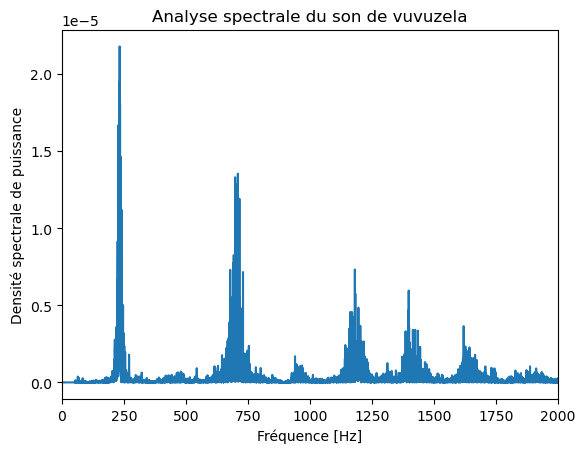

In [4]:
# ===== Analyse Spectrale =====

# Calcul du périodogramme
frequencies, power_spectrum = periodogram(vuvuzela_section, fs)

# Affichage du spectre de fréquence
tools.affichage_graph(frequencies, power_spectrum, "Fréquence [Hz]", "Densité spectrale de puissance", 0, 2000,"Analyse spectrale du son de vuvuzela")

On voit 4 principales fréquences :
$$f_{01} = 235 \; Hz$$
$$f_{02} = 710 \; Hz$$
$$f_{03} = 1181 \; Hz$$
$$f_{04} = 1402 \; Hz$$

Les fréquences de cassures correspondantes sont :
$$\omega_{01} = 1476,55 \; {rad.s^{-1}}$$
$$\omega_{02} = 4461,06 \; rad.s^{-1}$$
$$\omega_{03} = 7420,44 \; rad.s^{-1}$$
$$\omega_{04} = 8809,02 \; rad.s^{-1}$$

Calcul des coefficients d'amortissement

In [12]:
bands = [25, 51, 60, 64]
frequencies = [235, 710, 1181, 1402]
for idx in range (0, 4):
    m = bands[idx] / (2 * frequencies[idx])
    print("band : " + str(bands[idx]) + ", frequencies : " + str(frequencies[idx]) + ", m : " + str(m) + "\n") 
    

band : 25, frequencies : 235, m : 0.05319148936170213

band : 51, frequencies : 710, m : 0.03591549295774648

band : 60, frequencies : 1181, m : 0.02540220152413209

band : 64, frequencies : 1402, m : 0.02282453637660485



In [11]:
def RLC_Notch(T, w0, m, C):
    # Composant en fonction des parametres
    L = 1 / (w0 ** 2 * C) 
    R = 2 * m * np.sqrt(L / C)
    return R, L, C
    
def TwinT_Notch(T, w0, m, C):
    # Set the components from filter parameters
    R = 1 / (w0 * C)  # Solve for R given w0 and C
    return R, C
    
def ActiveTwinT_Notch(T, w0, m, C, R1 = 10**(3)):
    # Set the components from filter parameters
    R = 1 / (w0 * C)  # Solve for R given w0 and C
    R2 = R1 * ((1/(2 * m)) - 1)  # Calculate R2 based on desired gain T and given R1
    return R, C, R1, R2


pulsations = [1476.55, 4461.06, 7420.44, 8809.02]
m = 0.2
T = 1
C = 10*10**(-9)

for w in pulsations :
    print("\n ~~~ w =", w, "~~~ ")
    print("RLC_Notch", RLC_Notch(T, w, m, C))
    print("TwinT_Notch", TwinT_Notch(T, w, m, C))
    print("ActiveTwinT_Notch", ActiveTwinT_Notch(T, w, m, C))


 ~~~ w = 1476.55 ~~~ 
RLC_Notch (27090.17642477397, 45.86735367033621, 1e-08)
TwinT_Notch (67725.44106193492, 1e-08)
ActiveTwinT_Notch (67725.44106193492, 1e-08, 1000, 1500.0)

 ~~~ w = 4461.06 ~~~ 
RLC_Notch (8966.47881893541, 5.024858900651083, 1e-08)
TwinT_Notch (22416.197047338523, 1e-08)
ActiveTwinT_Notch (22416.197047338523, 1e-08, 1000, 1500.0)

 ~~~ w = 7420.44 ~~~ 
RLC_Notch (5390.515926279305, 1.816103871966927, 1e-08)
TwinT_Notch (13476.289815698261, 1e-08)
ActiveTwinT_Notch (13476.289815698261, 1e-08, 1000, 1500.0)

 ~~~ w = 8809.02 ~~~ 
RLC_Notch (4540.80022522369, 1.28867916783697, 1e-08)
TwinT_Notch (11352.000563059228, 1e-08)
ActiveTwinT_Notch (11352.000563059228, 1e-08, 1000, 1500.0)


On veut une atténuation de -15 db au minimum, on va donc calculer la bande passante des pics à -15 dB

In [6]:
from filters import ActiveTwinT_Notch

frequencies = [235, 710, 1181, 1402]
T = 1
m = 0.125

for freq in frequencies :
    
    # Fixer les paramètres du filtre
    w0 = 2 * np.pi * freq      # Fréquence de résonance (exemple : 1000 rad/s)
    
    # Fixer des valeurs pour les composants connus
    C = 1.1e-6        # Capacité connue (exemple : 1 µF)
    R1 = 10000       # Résistance connue (exemple : 1 kΩ)
    
    # Créer une instance de la classe
    notch_filter = ActiveTwinT_Notch(C=C, R1=R1)
    
    # Calculer les composants
    R, C, R1, R2 = notch_filter.set_components(T, w0, m)
    
    # Afficher les résultats
    print(f"R = {R:.2f} Ω")
    print(f"C = {C:.2e} F")
    print(f"R1 = {R1:.2f} Ω")
    print(f"R2 = {R2:.2f} Ω\n")


R = 615.69 Ω
C = 1.10e-06 F
R1 = 10000.00 Ω
R2 = 30000.00 Ω

R = 203.78 Ω
C = 1.10e-06 F
R1 = 10000.00 Ω
R2 = 30000.00 Ω

R = 122.51 Ω
C = 1.10e-06 F
R1 = 10000.00 Ω
R2 = 30000.00 Ω

R = 103.20 Ω
C = 1.10e-06 F
R1 = 10000.00 Ω
R2 = 30000.00 Ω

